In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import xgboost as xgb
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [2]:
drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/MyDrive/CS584/final_data_cleaned.csv')
df = pd.read_csv('/content/drive/.shortcut-targets-by-id/1JuvXZ8vO66_Vje9xLUzqnhe6nupbRU63/CS584/balanced_data_sentiment.csv')
df.head()

Mounted at /content/drive


,Unnamed: 0,tickers,companyName,accessionNumber,document,filingDate,url,content,price_today,price_3mo,price_change,direction,positive,negative,neutral
0,1,MMM,3M CO,0000066740-25-000063,mmm-20250630.htm,2025-07-18,https://www.sec.gov/Archives/edgar/data/000006...,Item 2. Management's Discussion and Analysis o...,153.229996,152.639999,-0.003850,0,0.132291,0.303619,0.564090
1,4,MMM,3M CO,0000066740-24-000080,mmm-20240630.htm,2024-07-26,https://www.sec.gov/Archives/edgar/data/000006...,Item 2. Management's Discussion and Analysis o...,127.160004,124.750000,-0.018953,0,0.082315,0.346704,0.570981
2,7,MMM,3M CO,0000066740-23-000058,mmm-20230630.htm,2023-07-25,https://www.sec.gov/Archives/edgar/data/000006...,Item 2. Management's Discussion and Analysis o...,91.831100,74.740807,-0.186106,0,0.047720,0.419279,0.533001
3,9,MMM,3M CO,0000066740-22-000076,mmm-20220930.htm,2022-10-25,https://www.sec.gov/Archives/edgar/data/000006...,Item 2. Management's Discussion and Analysis o...,99.080269,94.423080,-0.047004,0,0.067711,0.358310,0.573980
4,10,MMM,3M CO,0000066740-22-000065,mmm-20220630.htm,2022-07-27,https://www.sec.gov/Archives/edgar/data/000006...,Item 2. Management's Discussion and Analysis o...,116.103676,102.675583,-0.115656,0,0.085860,0.387758,0.526382


In [3]:
df.shape

(7746, 15)

In [4]:
df_train = df[df.filingDate < '2025-01-01']
df_test = df[df.filingDate >= '2025-01-01']

X_train = df_train[['positive', 'negative', 'neutral']]
y_train = df_train.direction
X_test = df_test[['positive', 'negative', 'neutral']]
y_test = df_test.direction

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


del df_train
del df_test
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(5816, 3)
(5816,)
(1454, 3)
(1454,)
(476, 3)
(476,)


In [5]:
model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=2,
    subsample=0.5,
    colsample_bytree=0.7,
    random_state=42,
    use_label_encoder=False,
    eval_metric='auc'
)


In [6]:

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:13:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

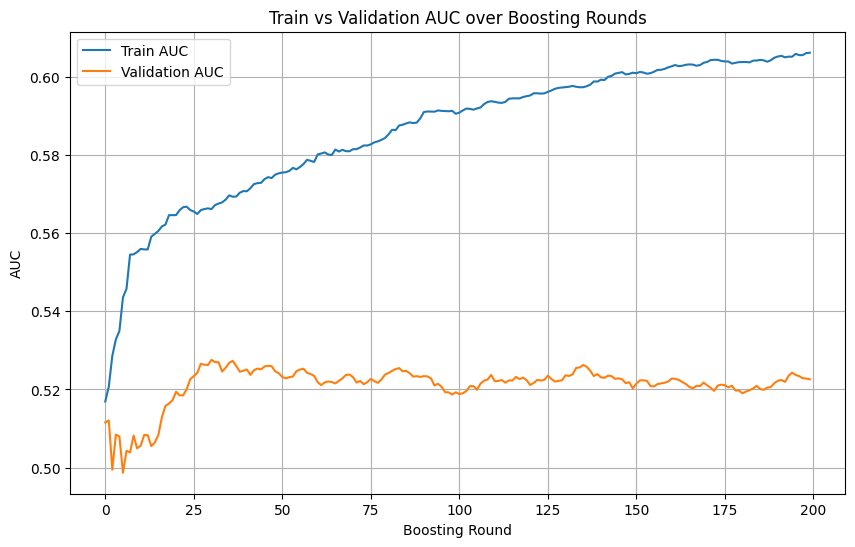

In [7]:
evals_result = model.evals_result()

train_auc = evals_result['validation_0']['auc']
val_auc = evals_result['validation_1']['auc']

plt.figure(figsize=(10,6))
plt.plot(train_auc, label='Train AUC')
plt.plot(val_auc, label='Validation AUC')
plt.xlabel('Boosting Round')
plt.ylabel('AUC')
plt.title('Train vs Validation AUC over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.4622
Test AUC: 0.4430
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.39      0.43       251
           1       0.44      0.55      0.49       225

    accuracy                           0.46       476
   macro avg       0.47      0.47      0.46       476
weighted avg       0.47      0.46      0.46       476

